In [2]:
import numpy as np
import pandas as pd


In [3]:
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select

engine = create_engine("sqlite+pysqlite:///GPSdata1.db", echo=False)

metadata_obj = MetaData()

players_table = Table("players", metadata_obj, autoload_with=engine)
sessions_data_table = Table("sessions_data", metadata_obj, autoload_with=engine)

In [4]:
from SQLalch_helpers import selectPlayerIDsSubQ
from SQLalch_helpers import selectSessionsDataScatter

# get player positions
positions = []

with engine.connect() as conn: 
    
    pos_stm = (
        select(players_table.c.position)
        .group_by(players_table.c.position)
    )

    positions = conn.execute(pos_stm).scalars().all() 





In [5]:
measure_columns = sessions_data_table.columns
measure_columns._all_columns

[Column('player_id', INTEGER(), table=<sessions_data>, nullable=False),
 Column('match_id', INTEGER(), table=<sessions_data>, nullable=False),
 Column('Duration', FLOAT(), table=<sessions_data>),
 Column('Distance', FLOAT(), table=<sessions_data>),
 Column('HSR', FLOAT(), table=<sessions_data>),
 Column('SD', FLOAT(), table=<sessions_data>),
 Column('Accels + Decels', INTEGER(), table=<sessions_data>),
 Column('PlayerLoad', FLOAT(), table=<sessions_data>),
 Column('Top Speed', FLOAT(), table=<sessions_data>),
 Column('Dis/min', FLOAT(), table=<sessions_data>),
 Column('HSR/min', FLOAT(), table=<sessions_data>),
 Column('SD/min', FLOAT(), table=<sessions_data>),
 Column('Accels + Decels /min', FLOAT(), table=<sessions_data>)]

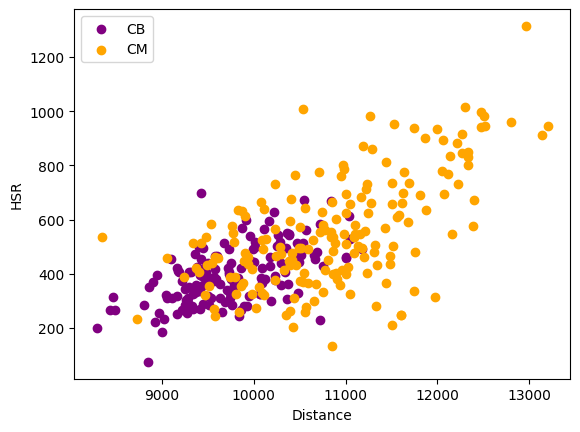

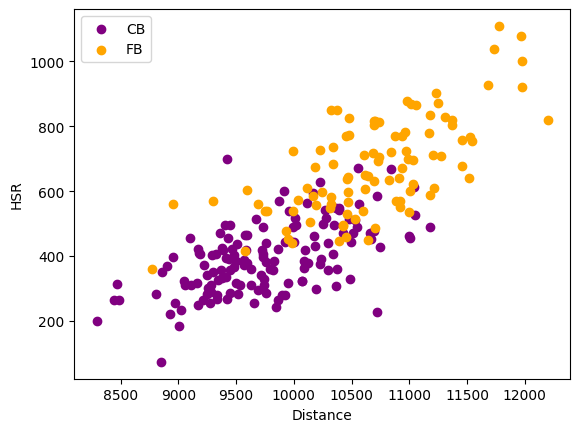

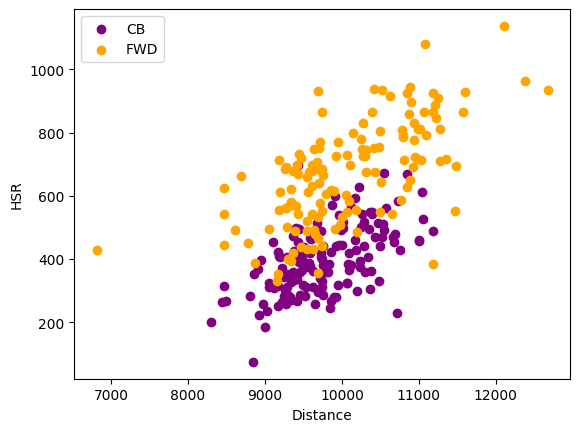

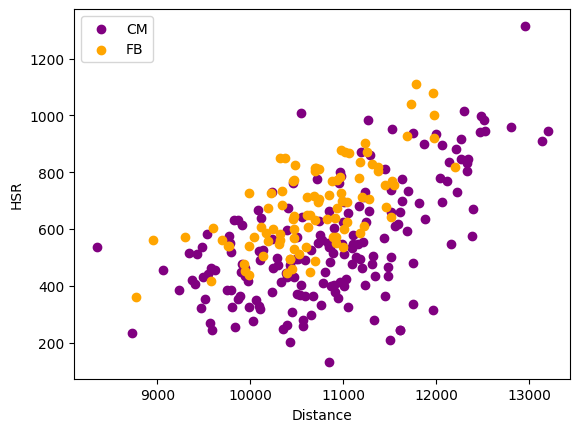

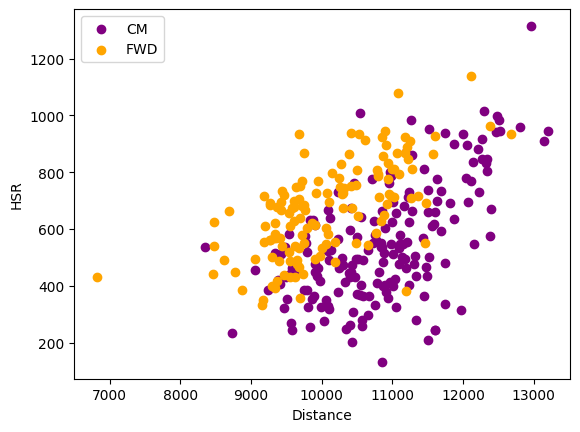

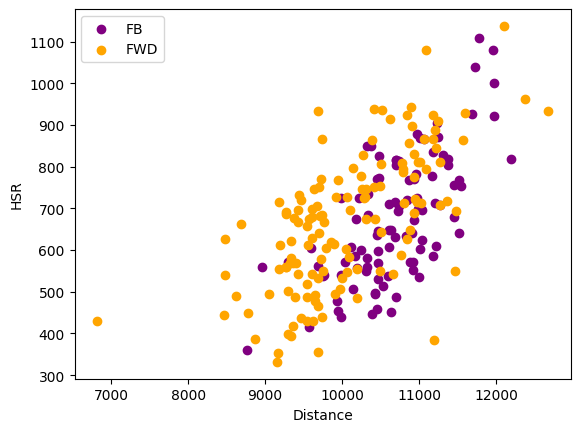

In [13]:
import matplotlib.pylab as plt

for i in range(0, len(positions)):
    for j in range(i + 1, len(positions)):

        pos1 = positions[i]
        pos2 = positions[j]

        # get positions ids
        pos1_subQ = selectPlayerIDsSubQ(pos1, players_table)
        pos2_subQ = selectPlayerIDsSubQ(pos2, players_table)

        # get columns
        measure_columns = sessions_data_table.columns
        
        # get data from ids
        pos1_data = selectSessionsDataScatter(pos1_subQ, measure_columns, sessions_data_table)
        pos2_data = selectSessionsDataScatter(pos2_subQ, measure_columns, sessions_data_table)

        # get dfs

        pos1_df = pd.DataFrame(pos1_data)
        pos2_df = pd.DataFrame(pos2_data)

        plt.scatter(pos1_df.Distance, pos1_df.HSR, color="purple", label = pos1)
        plt.scatter(pos2_df.Distance, pos2_df.HSR, color="orange", label = pos2 )
        plt.legend()
        plt.xlabel("Distance")
        plt.ylabel("HSR")

        plt.show()

    


In [7]:
pos_subQ = selectPlayerIDsSubQ("CB", players_table)
measure_columns = sessions_data_table.columns
pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
pos_df = pd.DataFrame(pos_data)
pos_df.columns

Index(['Accels + Decels', 'Accels + Decels /min', 'Dis/min', 'Distance',
       'Duration', 'HSR', 'HSR/min', 'PlayerLoad', 'SD', 'SD/min', 'Top Speed',
       'match_id', 'player_id'],
      dtype='object')

In [8]:
import seaborn as sns

0
 
0.1046 x - 624.9
1
 
0.135 x - 912.1
2
 
0.1615 x - 1049
3
 
0.1214 x - 555.8


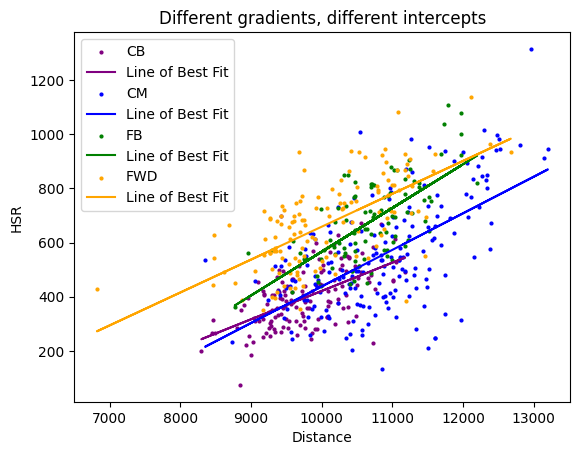

In [9]:
# plotting each position with own gradients


colours = ["purple", "blue", "green", "orange"]

for i, position in enumerate(positions):
    print(i)
    pos_subQ = selectPlayerIDsSubQ(position, players_table)
    measure_columns = sessions_data_table.columns
    pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
    pos_df = pd.DataFrame(pos_data)
    x_axis = pos_df["Distance"]
    y_axis = pos_df["HSR"]

    coefficients = np.polyfit(x_axis.values, y_axis.values, 1)
    poly = np.poly1d(coefficients)
    print(poly)

    plt.scatter(x_axis, y_axis, color=colours[i], label = positions[i], s=4)
    plt.plot(x_axis.values, poly(x_axis.values), color=colours[i], label='Line of Best Fit')

plt.legend()
plt.title("Different gradients, different intercepts")
plt.xlabel(x_axis.name)
plt.ylabel(y_axis.name)
plt.show()


-624.86153981 + 0.12469547 x
-912.10848229 + 0.12469547 x
-1048.60694083 + 0.12469547 x
-555.78425739 + 0.12469547 x


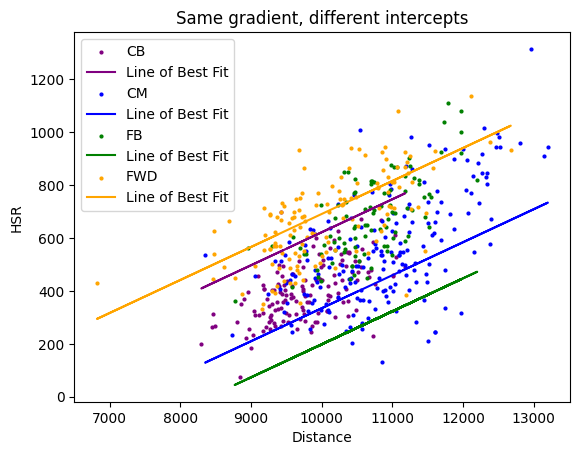

In [10]:
# plotting each position with same gradient, different intercepts

# get positional data for all players

with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table.c.Distance, sessions_data_table.c.HSR)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

all_df = pd.DataFrame(all_data)
x = all_df["Distance"].values
y = all_df["HSR"].values
all_M = np.polyfit(x, y, 1)[0]


colours = ["purple", "blue", "green", "orange"]

for i, position in enumerate(positions):
    pos_subQ = selectPlayerIDsSubQ(position, players_table)
    measure_columns = sessions_data_table.columns
    pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
    pos_df = pd.DataFrame(pos_data)
    x_axis = pos_df["Distance"]
    y_axis = pos_df["HSR"]

    group_C = np.polyfit(x_axis, y_axis, 1)[1]
    coefficients = [group_C, all_M]
    poly_sgdi = np.polynomial.Polynomial(coefficients)
    print(poly_sgdi)


    plt.scatter(x_axis, y_axis, color=colours[i], label = positions[i], s=4)
    plt.plot(x_axis.values, poly_sgdi(x_axis.values), color=colours[i], label='Line of Best Fit')

plt.legend()
plt.title("Same gradient, different intercepts")
plt.xlabel(x_axis.name)
plt.ylabel(y_axis.name)
plt.show()

0
1
2
3


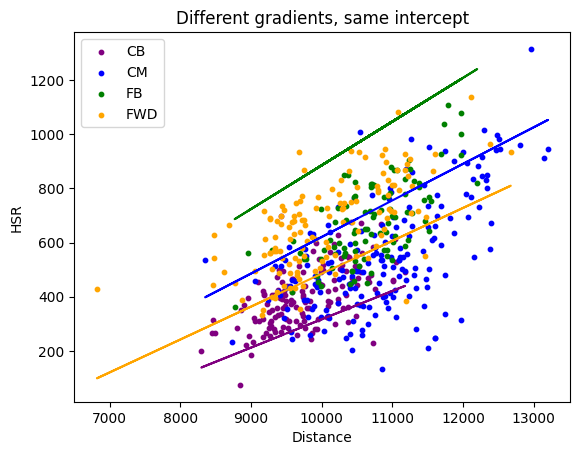

In [11]:
# plotting each position with same gradient

# get positional data for all players
independant = "Distance"
dependant = "HSR"

with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

all_df = pd.DataFrame(all_data)
x = all_df[independant].values
y = all_df[dependant].values
all_C = np.polyfit(x, y, 1)[1]


colours = ["purple", "blue", "green", "orange"]

for i, position in enumerate(positions):
    print(i)
    pos_subQ = selectPlayerIDsSubQ(position, players_table)
    measure_columns = sessions_data_table.columns
    pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
    pos_df = pd.DataFrame(pos_data)
    x_axis = pos_df[independant]
    y_axis = pos_df[dependant]

    group_M = np.polyfit(x_axis, y_axis, 1)[0]
    coefficients = [all_C, group_M]
    poly = np.polynomial.Polynomial(coefficients)

    plt.scatter(x_axis, y_axis, color=colours[i], label = positions[i], s=10)
    plt.plot(x_axis.values, poly(x_axis.values), color=colours[i])

plt.legend()
plt.title("Different gradients, same intercept")
plt.xlabel(x_axis.name)
plt.ylabel(y_axis.name)
plt.show()

In [12]:
# TODO: plot hyperplane

